In [1]:
# Import libs

import numpy as np
import geopandas as gpd
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as PolygonMat
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

from mpl_toolkits.basemap import Basemap
from area import area as area_geo
from geopy.distance import geodesic
from itertools import combinations
from shapely.geometry import box
from shapely.geometry import Polygon as PolygonS

In [2]:
# Define common variables

dfActors = pd.read_csv("dados/atores.csv", delimiter=";", decimal=',')

# Change format and translate
dfActors['id'] = dfActors['id'].replace('UD', '', regex=True)
dfActors['type'] = dfActors['type'].replace({'Area coleta':'Harvest area', 'UD':'HD'}, regex=True)


dfActors = dfActors.set_index('id')
dfActorsUD = dfActors[dfActors['type'] == 'HD']

base_map = Basemap(llcrnrlon=-54.9,llcrnrlat=-7.37,urcrnrlon=-52.6,urcrnrlat=-4.1,
         resolution='i', projection='merc', lat_0=-5.5, lon_0=-53.6)

# Plotting the networks

In [3]:
def create_figure(simple_map=True):
    if simple_map:
        fig = plt.figure(figsize = (15,13))
        ax = fig.add_subplot(111)
    else:
        fig = plt.figure(figsize=(17, 13))
        gs = GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.0)
        ax = fig.add_subplot(gs[:, :1])
        ax2 = fig.add_subplot(gs[1, 1])
        #fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 13), gridspec_kw={'width_ratios': [3, 1]})
        
    # Load shapefile
    base_map.readshapefile('shapefile/RESEX_ESEC', 'resex', drawbounds=False, ax=ax)
    base_map.readshapefile('shapefile/hidrografia', 'hidrografia', color='#8CD6FA', zorder=-1, ax=ax)

    # Fill resex polygon
    shape_resex = [PolygonMat(np.array(base_map.resex[0]), closed=True)]

    # Fill esec polygon
    shape_esec = [PolygonMat(np.array(base_map.resex[1]), closed=True)]

    # Fill polygon
    ax.add_collection(PatchCollection(shape_resex, facecolor= '#C4E3C3', linewidths=0., zorder=-2))
    ax.add_collection(PatchCollection(shape_esec, facecolor= '#CAFAD7', linewidths=0., zorder=-2))

    # Draw scale
    lon_left = base_map.llcrnrlon + 0.2 * (base_map.urcrnrlon - base_map.llcrnrlon)
    lat_bottom = base_map.llcrnrlat + 0.1 * (base_map.urcrnrlat - base_map.llcrnrlat)
    lon_right = lon_left + 5  # Small shift to the right for proper display
    base_map.drawmapscale(lon_left, lat_bottom, lon_right, lat_bottom, 100, units='km', barstyle='fancy', labelstyle='simple',
                   fontcolor='black', fillcolor1='w', fillcolor2='black', ax=ax)
    
    ax.axis('off')

    if simple_map:
        return fig, ax
    else:
        world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        brazil = world_map[world_map['name'] == 'Brazil']
        brazil.plot(ax=ax2, color='#C4E3C3')
                
        resex_data = gpd.read_file('shapefile/RESEX_ESEC.shp')
        resex_bounds = resex_data.total_bounds
        bbox = box(*resex_bounds)
        bbox_gdf = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=world_map.crs)
        bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='red', linewidth=2)

        ax2.set_xlim([-74, -34])  # Approximate longitudes of Brazil
        ax2.set_ylim([-34, 6])    # Approximate latitudes of Brazil
        ax2.set_xticks([])
        ax2.set_yticks([])

        return fig, (ax, ax2)

## First Network - parentesco

In [4]:
# Create data frames and network
dfParentescoLinks = pd.read_csv("dados/ligacoes_parentesco.csv")

# Change format and translate
dfParentescoLinks['source'] = dfParentescoLinks['source'].replace('UD', '', regex=True)
dfParentescoLinks['target'] = dfParentescoLinks['target'].replace('UD', '', regex=True)

G_parentesco = nx.from_pandas_edgelist(
    dfParentescoLinks, source = 'source', target = 'target', create_using=nx.Graph()
)

# Add nodes without link
all_nodes = list(dfActorsUD.index)
linked_nodes = list(G_parentesco.nodes)
missing_nodes = [node for node in all_nodes if node not in linked_nodes]

G_parentesco.add_nodes_from(missing_nodes)

# Set nodes attributes
nodes_attr = dfActorsUD.to_dict(orient = 'index')
nx.set_node_attributes(G_parentesco, nodes_attr)

In [5]:
print(f"The density is {nx.density(G_parentesco)}. The fragmentation is {1 - nx.density(G_parentesco)}")

The density is 0.06560283687943262. The fragmentation is 0.9343971631205674


In [6]:
## Make clustering analysis - https://networkx.org/documentation/stable/reference/algorithms/community.html

print("Greedy")
greedy = nx.community.greedy_modularity_communities(G_parentesco)

print("Partitions: ", greedy)
print("Modularity: ", nx.community.modularity(G_parentesco, greedy))
print("Partition Quality: ", nx.community.partition_quality(G_parentesco, greedy))

print("Naive")
naive = nx.community.naive_greedy_modularity_communities(G_parentesco)

print("Partitions: ", naive)
print("Modularity: ", nx.community.modularity(G_parentesco, naive))
print("Partition Quality: ", nx.community.partition_quality(G_parentesco, naive))

print("Louvain")
louvain = nx.community.louvain_communities(G_parentesco, seed=123)

print("Partitions: ", louvain)
print("Modularity: ", nx.community.modularity(G_parentesco, louvain))
print("Partition Quality: ", nx.community.partition_quality(G_parentesco, louvain))

print("Girvan")
girvan_it = nx.community.girvan_newman(G_parentesco)
girvan = [set(c) for c in next(girvan_it)]

print("Partitions: ", girvan)
print("Modularity: ", nx.community.modularity(G_parentesco, girvan))
print("Partition Quality: ", nx.community.partition_quality(G_parentesco, girvan))

Greedy
Partitions:  [frozenset({'44', '36', '48', '20', '25', '45', '19', '47', '15', '29'}), frozenset({'02', '08', '03', '07', '09', '01'}), frozenset({'14', '23', '12', '18', '41', '31'}), frozenset({'37', '43', '28', '30', '39', '34'}), frozenset({'06', '05', '11', '10'}), frozenset({'22', '32', '24', '40'}), frozenset({'27', '42', '26', '33'}), frozenset({'04'}), frozenset({'13'}), frozenset({'16'}), frozenset({'17'}), frozenset({'21'}), frozenset({'35'}), frozenset({'38'}), frozenset({'46'})]
Modularity:  0.7362125639152666
Partition Quality:  (0.9324324324324325, 0.9609929078014184)
Naive
Partitions:  [frozenset({'44', '36', '48', '20', '25', '45', '19', '47', '15', '29'}), frozenset({'02', '08', '03', '07', '09', '01'}), frozenset({'14', '23', '12', '18', '41', '31'}), frozenset({'37', '43', '28', '30', '39', '34'}), frozenset({'10', '06', '05', '11'}), frozenset({'22', '32', '24', '40'}), frozenset({'27', '42', '26', '33'}), frozenset({'04'}), frozenset({'13'}), frozenset({'16

Based on the results, we opt for the Louvin algorithm

In [7]:
# Make dict of node and communities, that will be used to set the node color

last_non_unitary_id = 7
louvain = nx.community.louvain_communities(G_parentesco, seed=123)
node_to_community = dict()
for community_id, elements in enumerate(louvain[:last_non_unitary_id]):
    for element in elements:
        node_to_community[element] = community_id
        
nodes_without_community = [el.pop() for el in louvain[last_non_unitary_id:]]

for node in nodes_without_community:
    node_to_community[node] = last_non_unitary_id
    
# Set color map
cmap = cm.get_cmap('gist_rainbow')
norm = plt.Normalize(0, 1)
colors = cmap(norm(np.linspace(0, 1, last_non_unitary_id+1)))

# Set node color
community_to_color = dict([[idx, color] for (idx, color) in enumerate(colors)])
node_color = [community_to_color[node_to_community[node]] for node in G_parentesco.nodes()]

# Print nodes with higher degree per community
number_nodes_per_cluster = 2
degrees = dict(G_parentesco.degree)
for community_id in range(7):
    print(f"Community: {community_id}")
    community_nodes = [node for (node, comm_id) in node_to_community.items() if comm_id == community_id]
    filtered_degrees = dict([(node, degree) for (node, degree) in degrees.items() if node in community_nodes])
    
    for node in sorted(filtered_degrees, key=filtered_degrees.get, reverse=True)[0:number_nodes_per_cluster]:
        print(f"Node {node}, degree: {filtered_degrees[node]}")

Community: 0
Node 02, degree: 6
Node 07, degree: 5
Community: 1
Node 11, degree: 4
Node 05, degree: 2
Community: 2
Node 14, degree: 5
Node 18, degree: 5
Community: 3
Node 22, degree: 3
Node 24, degree: 3
Community: 4
Node 27, degree: 3
Node 26, degree: 2
Community: 5
Node 43, degree: 5
Node 37, degree: 4
Community: 6
Node 20, degree: 9
Node 45, degree: 7


/tmp/ipykernel_68878/3207513230.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_rainbow')


In [8]:
## Create dataframe to be used in area of cluster analysis
dfActorsParentesco = dfActorsUD[['latitude', 'longitude']].copy(deep=True)
dfActorsParentesco["community"] = pd.Series(node_to_community)
dfActorsParentesco = dfActorsParentesco[dfActorsParentesco["community"] != last_non_unitary_id]

/tmp/ipykernel_68878/203036515.py:38: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


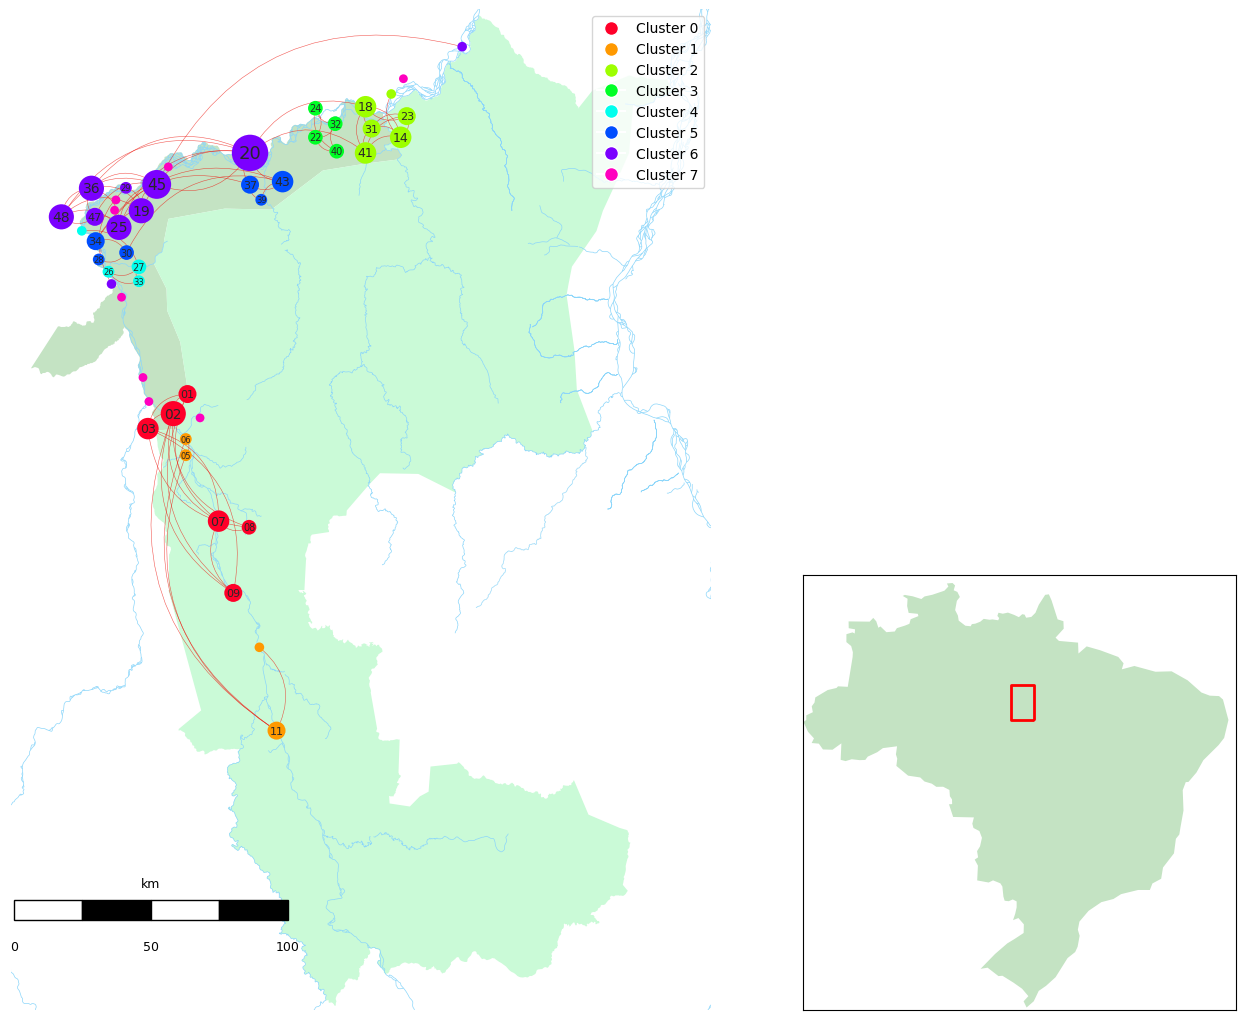

In [9]:
# Set degree
degrees = dict(G_parentesco.degree)
node_size = [(5 + degree*degree) * 8 for degree in degrees.values()]

# Get coordinates of actors
uds_position = {}
for row in dfActorsUD.itertuples():
    uds_position[row.Index] = base_map(row.longitude_parentesco, row.latitude_parentesco)


# Create figure
fig, (ax,ax2) = create_figure(simple_map=False)

# Draw actors and edges
nx.draw_networkx_nodes(
    G_parentesco, pos = uds_position, node_color = node_color, node_size=node_size, linewidths=0, ax=ax
)
nx.draw_networkx_edges(
    G_parentesco, nodelist = list(G_parentesco.nodes()),
    pos = uds_position, edge_color='#ed130b', alpha=0.7, node_size=node_size,
    arrows=True, connectionstyle="arc3,rad=0.4", arrowsize=0.1, width=0.4, ax=ax
)

## Draw label varying font size
for node_label, (x, y) in uds_position.items():
    if degrees[node_label] > 1: 
        ax.text(x, y, node_label, fontsize=(4+degrees[node_label]), ha='center', va='center', color='#282828')
    
## Draw legend 
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"Cluster {community_id}", markerfacecolor=color, markersize=10)
        for (community_id, color) in community_to_color.items()
]
ax.legend(handles=legend_elements, loc='upper right')
    
plt.savefig("results/rede_parentesco_community.pdf", format = "pdf")

## Second Network - relações

In [10]:
# Create data frames and network
dfPropriedadeLinks = pd.read_csv("dados/ligacoes_propriedade.csv")

# Change format and translate
dfPropriedadeLinks['source'] = dfPropriedadeLinks['source'].replace('UD', '', regex=True)
dfPropriedadeLinks['target'] = dfPropriedadeLinks['target'].replace('UD', '', regex=True)
dfPropriedadeLinks['type'] = dfPropriedadeLinks['type'].replace({'heranca':'Inheritance', 'sociedade':'Society',
                                                                 'aviamento':'Aviamento', 'doacao':'Donation',
                                                                 'aluguel':'Rental', 'compra':'Purchase',
                                                                }, regex=True)

G_propriedade = nx.from_pandas_edgelist(dfPropriedadeLinks, source = 'source', target = 'target', 
                            edge_attr='type', create_using=nx.Graph())

# Add nodes without link
all_nodes = list(dfActorsUD.index)
linked_nodes = list(G_propriedade.nodes)
missing_nodes = [node for node in all_nodes if node not in linked_nodes]

G_propriedade.add_nodes_from(missing_nodes)

# Set nodes attributes|
nodes_attr = dfActorsUD.to_dict(orient = 'index')
nx.set_node_attributes(G_propriedade, nodes_attr)

print(len(missing_nodes))
print(len(all_nodes))

2
48


In [11]:
# Show density
print(f"The density is {nx.density(G_propriedade)}. The fragmentation is {1 - nx.density(G_propriedade)}")

The density is 0.038120567375886524. The fragmentation is 0.9618794326241135


In [12]:
## Make clustering analysis - https://networkx.org/documentation/stable/reference/algorithms/community.html

print("Greedy")
greedy = nx.community.greedy_modularity_communities(G_propriedade)

print("Partitions: ", greedy)
print("Modularity: ", nx.community.modularity(G_propriedade, greedy))
print("Partition Quality: ", nx.community.partition_quality(G_propriedade, greedy))

print("Naive")
naive = nx.community.naive_greedy_modularity_communities(G_propriedade)

print("Partitions: ", naive)
print("Modularity: ", nx.community.modularity(G_propriedade, naive))
print("Partition Quality: ", nx.community.partition_quality(G_propriedade, naive))

print("Louvain")
louvain = nx.community.louvain_communities(G_propriedade, seed=123)

print("Partitions: ", louvain)
print("Modularity: ", nx.community.modularity(G_propriedade, louvain))
print("Partition Quality: ", nx.community.partition_quality(G_propriedade, louvain))

print("Girvan")
girvan_it = nx.community.girvan_newman(G_propriedade)
girvan = [set(c) for c in next(girvan_it)]

print("Partitions: ", girvan)
print("Modularity: ", nx.community.modularity(G_propriedade, girvan))
print("Partition Quality: ", nx.community.partition_quality(G_propriedade, girvan))

Greedy
Partitions:  [frozenset({'32', '44', '43', '26', '33', '37', '46', '27', '39'}), frozenset({'02', '04', '06', '05', '03', '01'}), frozenset({'20', '25', '45', '42', '48', '47'}), frozenset({'14', '23', '18', '41', '31'}), frozenset({'35', '16', '36', '19', '29'}), frozenset({'07', '08', '09'}), frozenset({'22', '40', '24'}), frozenset({'28', '30', '34'}), frozenset({'11', '10'}), frozenset({'13', '12'}), frozenset({'17', '21'}), frozenset({'15'}), frozenset({'38'})]
Modularity:  0.8201730665224446
Partition Quality:  (0.9534883720930233, 0.9476950354609929)
Naive
Partitions:  [frozenset({'44', '32', '26', '43', '33', '37', '46', '27', '39'}), frozenset({'35', '16', '36', '25', '19', '42', '29'}), frozenset({'02', '04', '06', '05', '03', '01'}), frozenset({'14', '23', '18', '41', '31'}), frozenset({'45', '20', '48', '47'}), frozenset({'07', '08', '09'}), frozenset({'22', '40', '24'}), frozenset({'28', '30', '34'}), frozenset({'15', '11', '10'}), frozenset({'13', '12'}), frozenset

In [13]:
# Make dict of node and communities, that will be used to set the node color
last_non_unitary_id = 11
louvain = nx.community.louvain_communities(G_propriedade, seed=123)
node_to_community = dict()
for community_id, elements in enumerate(louvain[:last_non_unitary_id]):
    for element in elements:
        node_to_community[element] = community_id
        if community_id == 2:
            node_to_community[element] = 4
        if community_id == 4:
            node_to_community[element] = 2
        if community_id == 8:
            node_to_community[element] = 1
        if community_id == 1:
            node_to_community[element] = 8
        
nodes_without_community = [el.pop() for el in louvain[last_non_unitary_id:]]

for node in nodes_without_community:
    node_to_community[node] = last_non_unitary_id
    
# Set color map
cmap = cm.get_cmap('gist_rainbow')
norm = plt.Normalize(0, 1)
colors = cmap(norm(np.linspace(0, 1, last_non_unitary_id+1)))

# Set node color
community_to_color = dict([[idx, color] for (idx, color) in enumerate(colors)])
node_color = [community_to_color[node_to_community[node]] for node in G_propriedade.nodes()]

# Print nodes with higher degree per community
number_nodes_per_cluster = 2
degrees = dict(G_propriedade.degree)
for community_id in range(last_non_unitary_id):
    print(f"Community: {community_id}")
    community_nodes = [node for (node, comm_id) in node_to_community.items() if comm_id == community_id]
    filtered_degrees = dict([(node, degree) for (node, degree) in degrees.items() if node in community_nodes])
    
    for node in sorted(filtered_degrees, key=filtered_degrees.get, reverse=True)[0:number_nodes_per_cluster]:
        print(f"Node {node}, degree: {filtered_degrees[node]}")

Community: 0
Node 02, degree: 4
Node 06, degree: 3
Community: 1
Node 22, degree: 2
Node 24, degree: 2
Community: 2
Node 14, degree: 4
Node 18, degree: 3
Community: 3
Node 12, degree: 1
Node 13, degree: 1
Community: 4
Node 10, degree: 1
Node 11, degree: 1
Community: 5
Node 29, degree: 3
Node 16, degree: 2
Community: 6
Node 17, degree: 1
Node 21, degree: 1
Community: 7
Node 25, degree: 4
Node 20, degree: 2
Community: 8
Node 08, degree: 2
Node 07, degree: 1
Community: 9
Node 37, degree: 3
Node 27, degree: 3
Community: 10
Node 30, degree: 2
Node 34, degree: 1


/tmp/ipykernel_68878/4172598271.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_rainbow')


In [14]:
## Create dataframe to be used in area of cluster analysis
dfActorsPropriedade = dfActorsUD[['latitude', 'longitude']].copy(deep=True)
dfActorsPropriedade["community"] = pd.Series(node_to_community)
dfActorsPropriedade = dfActorsPropriedade[dfActorsPropriedade["community"] != last_non_unitary_id]

/tmp/ipykernel_68878/203036515.py:38: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


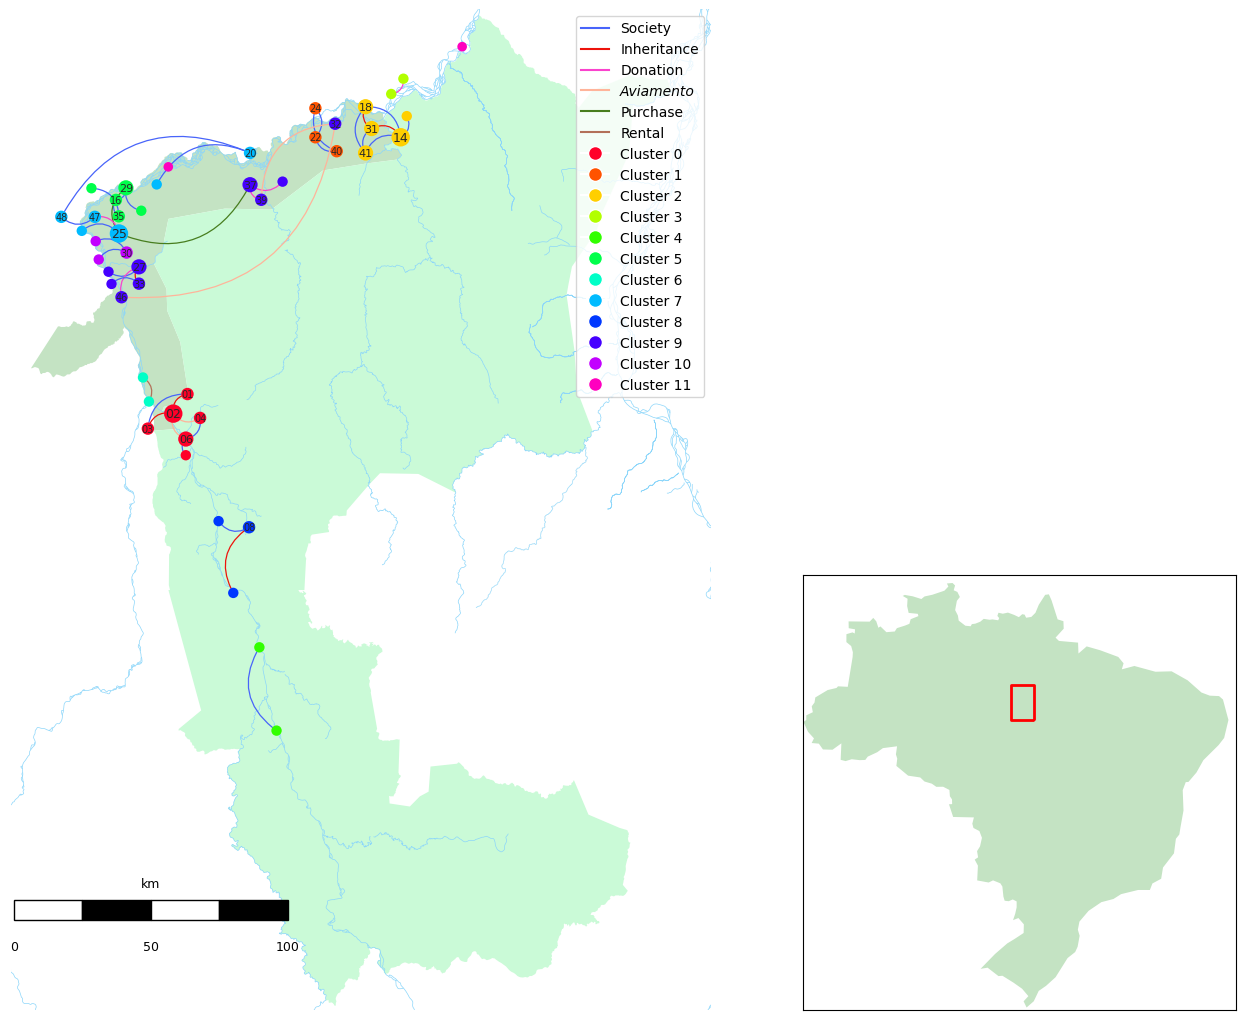

In [15]:
# Set degree
degrees = dict(G_propriedade.degree)
node_size = [(6 + degrees[node]**2) * 8 for node in G_propriedade.nodes()]

# Get coordinates of actors
uds_position = {}
for row in dfActorsUD.itertuples():
    uds_position[row.Index] = base_map(row.longitude_propriedade,row.latitude_propriedade)
    
# Define edges colors
edges = G_propriedade.edges()
edge_colors_dict = { 
    'Society': '#4864FA', 'Inheritance': '#ed130b', 'Donation': '#FA43CD', 
    'Aviamento': '#FFB49A', 'Purchase': '#477D1E', 'Rental': '#B37059' 
}
edge_colors = [edge_colors_dict[G_propriedade[u][v]['type']] for u,v in edges]


# Create figure
fig, (ax,ax2) = create_figure(simple_map=False)

# Draw actors and edges
nx.draw_networkx_nodes(
    G_propriedade, nodelist = list(G_propriedade.nodes()), pos = uds_position, node_color = node_color, 
    node_size=node_size, linewidths=0, ax=ax
)
nx.draw_networkx_edges(
    G_propriedade, pos = uds_position, edge_color=edge_colors, alpha=1.0, node_size=node_size,
    arrows=True, connectionstyle="arc3,rad=0.45", arrowsize=0.1, width=0.9, ax=ax
)

## Draw label varying font size
for node_label, (x, y) in uds_position.items():
    if degrees[node_label] > 1: 
        ax.text(x, y, node_label, fontsize=(5+degrees[node_label]), ha='center', va='center', color='#282828')

        
# Draw legend
handles, labels = plt.gca().get_legend_handles_labels()
edges = [Line2D([0], [0], label=name.title(), color=color) for name, color in edge_colors_dict.items()]

nodes = [
    Line2D([0], [0], marker='o', color='w', label=f"Cluster {community_id}", markerfacecolor=color, markersize=10)
        for (community_id, color) in community_to_color.items()
]

handles.extend(edges + nodes)
legend = ax.legend(handles=handles)

# Change label to italic
aviamento_text = legend.get_texts()[3]
aviamento_text.set_fontstyle("italic")

plt.savefig("results/rede_propriedade_community.pdf", format = "pdf")

## Third Network - areas coleta

In [16]:
# Create data frames and network

dfColetaLinks = pd.read_csv("dados/ligacoes_areas_coleta.csv", delimiter=",")
dfColetaLinks = dfColetaLinks.drop(['longitude', 'latitude'], axis=1)

# Change format and translate
dfColetaLinks['source'] = dfColetaLinks['source'].replace('UD', '', regex=True)
dfColetaLinks['target'] = dfColetaLinks['target'].replace('UD', '', regex=True)


G_coleta = nx.from_pandas_edgelist(
    dfColetaLinks, source = 'source', target = 'target', create_using=nx.Graph()
)


# Add nodes without link
all_nodes = list(dfActors.index)
linked_nodes = list(G_coleta.nodes)
missing_nodes = [node for node in all_nodes if node not in linked_nodes]

G_coleta.add_nodes_from(missing_nodes)

# Set nodes attributes
nodes_attr = dfActors.to_dict(orient = 'index')
nx.set_node_attributes(G_coleta, nodes_attr)

In [17]:
# Set degree

degrees = dict(G_coleta.degree)
size = lambda degree : -150 + 350 / (1 + np.exp(-0.15 * degree))
node_size = [
    (size(degree)) if dfActors.loc[node]['type'] == 'HD' else 7 for (node, degree) in degrees.items()
]

# Get coordinates of actors
uds_position = {}
for row in dfActors.itertuples():
    uds_position[row.Index] = base_map(row.longitude_area_coleta,row.latitude_area_coleta)
    
# Set node colors
node_color = ['#c197e8' if (dfActors.loc[node]['type'] == 'HD') else '#0c10f3' for node in G_coleta.nodes()]

In [18]:
#L = [node for node in G.nodes() if G.node[node]['attr1']=='beta']

number_UD = len(dfActors[dfActors['type'] == 'HD'])
number_coleta = len(dfActors[dfActors['type'] == 'Harvest area'])
density = 2 * nx.number_of_edges(G_coleta) / (number_UD * number_coleta)

print(f"The density is {density}. The fragmentation is {1 - density}")

The density is 0.06024774774774775. The fragmentation is 0.9397522522522522


/tmp/ipykernel_68878/203036515.py:38: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


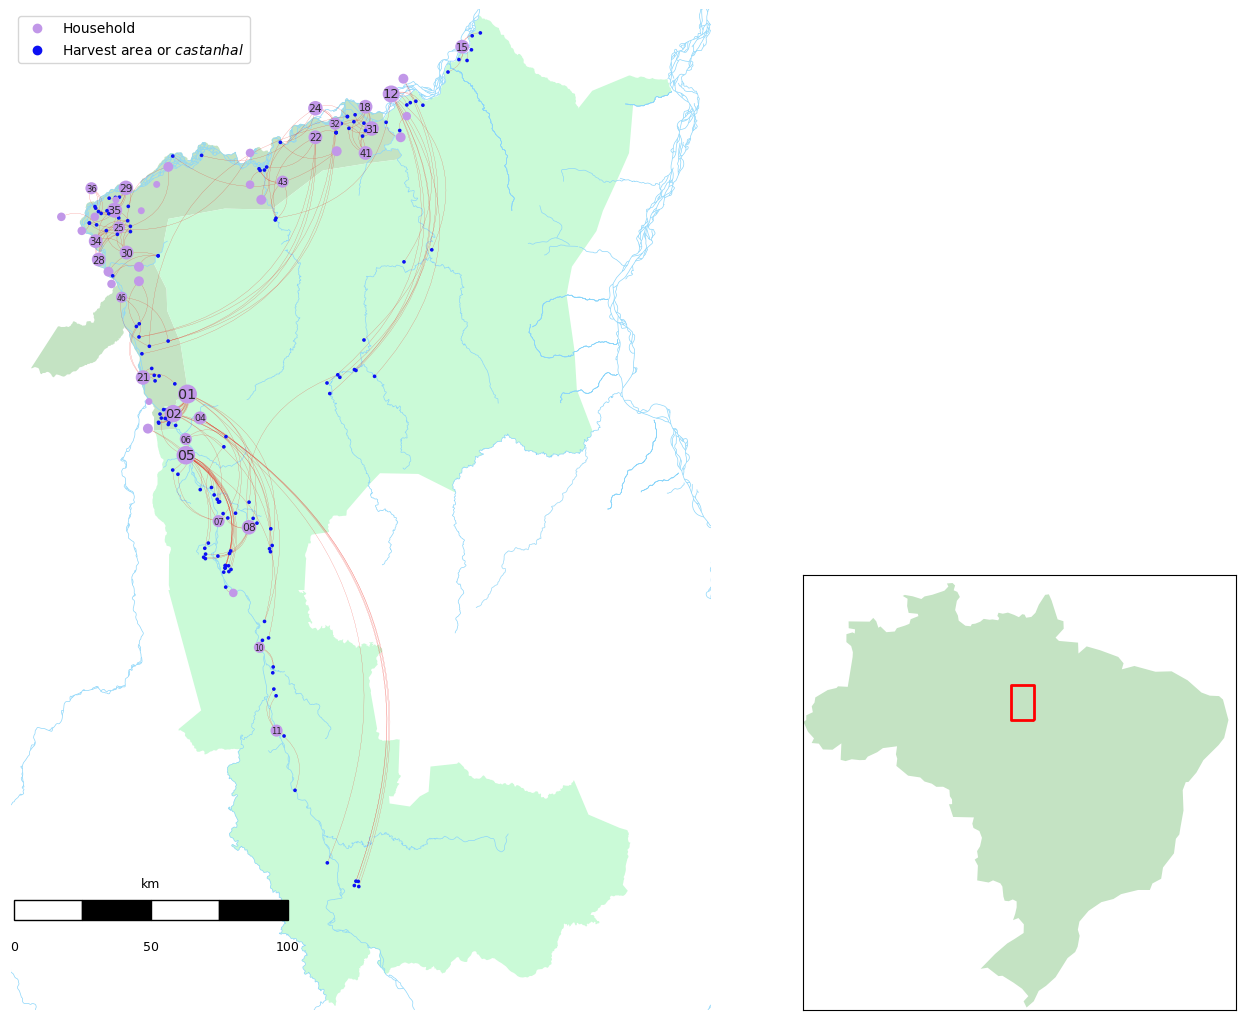

In [19]:
# Create figure
fig, (ax,ax2) = create_figure(simple_map=False)
    
# Draw actors and edges
nx.draw_networkx_nodes(
    G_coleta, pos = uds_position, node_color = node_color, node_size=node_size, linewidths=0, ax=ax
)
nx.draw_networkx_edges(
    G_coleta, pos = uds_position, edge_color='#ed130b', alpha=0.7, node_size=node_size,
    arrows=True, connectionstyle="arc3,rad=-0.4", arrowsize=0.1, width=0.15, ax=ax
)

## Draw label varying font size
for node_label, (x, y) in uds_position.items():
    if degrees[node_label] > 2 and dfActors.loc[node_label]['type'] == 'HD':
        fontsize = (-3.5 + 14 / (1 + np.exp(-0.2 * degrees[node_label])))
        ax.text(x, y, node_label, fontsize=fontsize, ha='center', va='center', color='#282828')

        
## Draw labels
handles, labels = plt.gca().get_legend_handles_labels()
line1 = Line2D([], [], label='Household', color="#c197e8", marker='o', linewidth=0)
line2 = Line2D([], [], label='Harvest area or $\mathit{castanhal}$', color="#0c10f3", marker='o', linewidth=0)

handles.extend([line1, line2])
ax.legend(handles=handles)

plt.savefig("results/rede_area_coleta.pdf", format = "pdf")

# Analysis

## Histograms distance

In [20]:
def compute_distance(row):
    coords_1 = (row.latitude_source, row.longitude_source)
    coords_2 = (row.latitude_target, row.longitude_target)
    
    return geodesic(coords_1, coords_2).km

In [21]:
# Get parentesco dataframe with links and positions of source and target node

dfParentescoDistance = dfParentescoLinks.merge(
    dfActorsUD, right_on='id', left_on='source',  how='left'
)
dfParentescoDistance = dfParentescoDistance.merge(
    dfActorsUD, right_on='id', left_on='target',  how='left', suffixes=['', '_target']
)
relevant_collums = [
    'source', 'target', 'latitude', 'longitude', 'latitude_target', 'longitude_target'
]
rename = {'latitude': 'latitude_source', 'longitude': 'longitude_source'}

dfParentescoDistance = dfParentescoDistance[relevant_collums]
dfParentescoDistance = dfParentescoDistance.rename(columns=rename)


# Compute distance between nodes for each link
dfParentescoDistance['distance'] = dfParentescoDistance.apply(compute_distance, axis=1)

dfParentescoDistance.sort_values('distance').head(25)

,source,target,latitude_source,longitude_source,latitude_target,longitude_target,distance
74,47,48,-4.7804,-54.6442,-4.7804,-54.6442,0.00000
38,20,37,-4.6012,-54.1146,-4.6012,-54.1146,0.00000
20,14,23,-4.4708,-53.6679,-4.4708,-53.6679,0.00000
40,22,24,-4.4756,-53.8300,-4.4756,-53.8300,0.00000
41,22,32,-4.4756,-53.8300,-4.4756,-53.8300,0.00000
42,22,40,-4.4756,-53.8300,-4.4756,-53.8300,0.00000
45,24,32,-4.4756,-53.8300,-4.4756,-53.8300,0.00000
46,24,40,-4.4756,-53.8300,-4.4756,-53.8300,0.00000
14,07,08,-5.7753,-54.2179,-5.7753,-54.2179,0.00000
49,25,47,-4.7804,-54.6442,-4.7804,-54.6442,0.00000


In [22]:
dfPropriedadeDistance = dfPropriedadeLinks.merge(
    dfActorsUD, right_on='id', left_on='source',  how='left'
)
dfPropriedadeDistance = dfPropriedadeDistance.merge(
    dfActorsUD, right_on='id', left_on='target',  how='left', suffixes=['', '_target']
)

dfPropriedadeDistance.head()

,source,target,type_x,type_y,familia,regiao,latitude,longitude,latitude_parentesco,longitude_parentesco,...,familia_target,regiao_target,latitude_target,longitude_target,latitude_parentesco_target,longitude_parentesco_target,latitude_propriedade_target,longitude_propriedade_target,latitude_area_coleta_target,longitude_area_coleta_target
0,01,02,Inheritance,HD,Mauricio Neves da Silva,Ressaca,-5.4198,-54.3734,-5.360,-54.3200,...,Manoel Messias (Manoel da Cachoeirinha),Cachoeirinha,-5.4265,-54.3767,-5.4240,-54.3667,-5.4240,-54.3667,-5.4240,-54.3667
1,01,03,Society,HD,Mauricio Neves da Silva,Ressaca,-5.4198,-54.3734,-5.360,-54.3200,...,José Martins da Silva,Cachoeirinha,-5.4265,-54.3767,-5.4730,-54.4500,-5.4730,-54.4500,-5.4730,-54.4500
2,02,03,Inheritance,HD,Manoel Messias (Manoel da Cachoeirinha),Cachoeirinha,-5.4265,-54.3767,-5.424,-54.3667,...,José Martins da Silva,Cachoeirinha,-5.4265,-54.3767,-5.4730,-54.4500,-5.4730,-54.4500,-5.4730,-54.4500
3,02,06,Aviamento,HD,Manoel Messias (Manoel da Cachoeirinha),Cachoeirinha,-5.4265,-54.3767,-5.424,-54.3667,...,Benedito Gomes da Silva (Bené),Triunfo 2,-5.4731,-54.3555,-5.5071,-54.3255,-5.5071,-54.3255,-5.5071,-54.3255
4,02,04,Aviamento,HD,Manoel Messias (Manoel da Cachoeirinha),Cachoeirinha,-5.4265,-54.3767,-5.424,-54.3667,...,Raimundo Silva de Castro (Raimundo Nazário),Sorriso Lindo,-5.4456,-54.3687,-5.4380,-54.2787,-5.4380,-54.2787,-5.4380,-54.2787


In [23]:
# Get propriedade dataframe with links and positions of source and target node

dfPropriedadeDistance = dfPropriedadeLinks.merge(
    dfActorsUD, right_on='id', left_on='source',  how='left'
)
dfPropriedadeDistance = dfPropriedadeDistance.merge(
    dfActorsUD, right_on='id', left_on='target',  how='left', suffixes=['', '_target']
)
relevant_collums = [
    'source', 'target', 'latitude', 'longitude', 'latitude_target', 'longitude_target', 'type_x'
]
rename = {'latitude': 'latitude_source', 'longitude': 'longitude_source', 'type_x': 'type'}

dfPropriedadeDistance = dfPropriedadeDistance[relevant_collums]
dfPropriedadeDistance = dfPropriedadeDistance.rename(columns=rename)

dfPropriedadeDistance['distance'] = dfPropriedadeDistance.apply(compute_distance, axis=1)

dfPropriedadeDistance.sort_values('distance').tail(22)

,source,target,latitude_source,longitude_source,latitude_target,longitude_target,type,distance
23,19,29,-4.7004,-54.5417,-4.7065,-54.5662,Society,2.800652
5,04,06,-5.4456,-54.3687,-5.4731,-54.3555,Society,3.374592
31,25,42,-4.7804,-54.6442,-4.8132,-54.6671,Society,4.428222
47,37,43,-4.6012,-54.1146,-4.6246,-54.0777,Donation,4.843595
44,37,39,-4.6012,-54.1146,-4.6246,-54.0777,Donation,4.843595
3,02,06,-5.4265,-54.3767,-5.4731,-54.3555,Aviamento,5.663509
13,14,18,-4.4708,-53.6679,-4.4614,-53.7353,Society,7.552180
16,14,31,-4.4708,-53.6679,-4.4614,-53.7353,Inheritance,7.552180
15,14,31,-4.4708,-53.6679,-4.4614,-53.7353,Society,7.552180
17,14,41,-4.4708,-53.6679,-4.4614,-53.7353,Society,7.552180


In [24]:
# Get area de coleta dataframe with links and positions of source and target node

dfColetaDistance = dfColetaLinks.merge(
    dfActors, right_on='id', left_on='source',  how='left'
)
dfColetaDistance = dfColetaDistance.merge(
    dfActors, right_on='id', left_on='target',  how='left', suffixes=['', '_target']
)
relevant_collums = [
    'source', 'target', 'latitude', 'longitude', 'latitude_target', 'longitude_target'
]
rename = {'latitude': 'latitude_source', 'longitude': 'longitude_source'}

dfColetaDistance = dfColetaDistance[relevant_collums]
dfColetaDistance = dfColetaDistance.rename(columns=rename)


dfColetaDistance['distance'] = dfColetaDistance.apply(compute_distance, axis=1)

dfColetaDistance.sort_values('distance').tail(10)

,source,target,latitude_source,longitude_source,latitude_target,longitude_target,distance
80,22,Igarapé do Gelo 1,-4.4756,-53.8300,-5.203800,-54.445200,105.552014
81,32,Igarapé do Gelo 1,-4.4756,-53.8300,-5.203800,-54.445200,105.552014
162,12,Pedro Jales,-4.3783,-53.6510,-5.323900,-53.861900,107.151396
213,32,Vithor,-4.4756,-53.8300,-5.228300,-54.469600,109.368366
178,12,Pontal (Rio Novo),-4.3783,-53.6510,-5.358400,-53.852700,110.666706
198,04,Samaúma 2,-5.4456,-54.3687,-6.890500,-53.860800,169.386692
35,04,Bom Futuro,-5.4456,-54.3687,-6.950300,-53.766900,179.234192
137,04,Mangueira,-5.4456,-54.3687,-6.951078,-53.759269,179.629430
138,04,Morada Nova,-5.4456,-54.3687,-6.964500,-53.772100,180.481419
62,04,Duas Irmãs,-5.4456,-54.3687,-6.967800,-53.757500,181.417249


In [25]:
dfDistanceAggregation = pd.concat([
    dfParentescoDistance[['distance']].assign(kind='Parentesco real'),
    dfPropriedadeDistance[['distance']].assign(kind='Propriedade entre UD'),
    dfColetaDistance[['distance']].assign(kind='UDs e áreas de coleta')
])

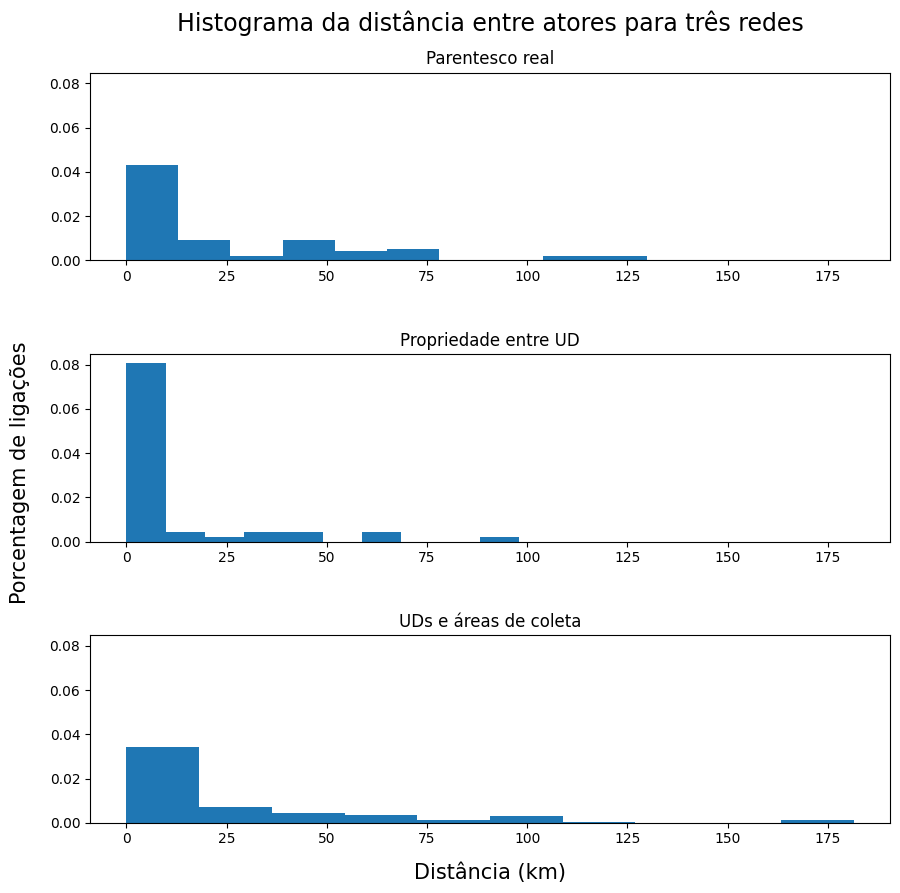

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 10))

dfDistanceAggregation.hist(column=["distance"], by="kind", bins=10, ax=axes, density=True)

plt.xticks(rotation=0)
for ax in axes.flatten(): ax.xaxis.set_tick_params(labelbottom=True)

fig.text(0.5,0.95, "Histograma da distância entre atores para três redes", ha="center", va="center", fontsize=17)
fig.text(0.5,0.1, "Distância (km)", ha="center", va="center", fontsize=15)
fig.text(0.03,0.5, "Porcentagem de ligações", ha="center", va="center", rotation=90, fontsize=15)


plt.savefig("results/distance_histogram.png", format = "png")

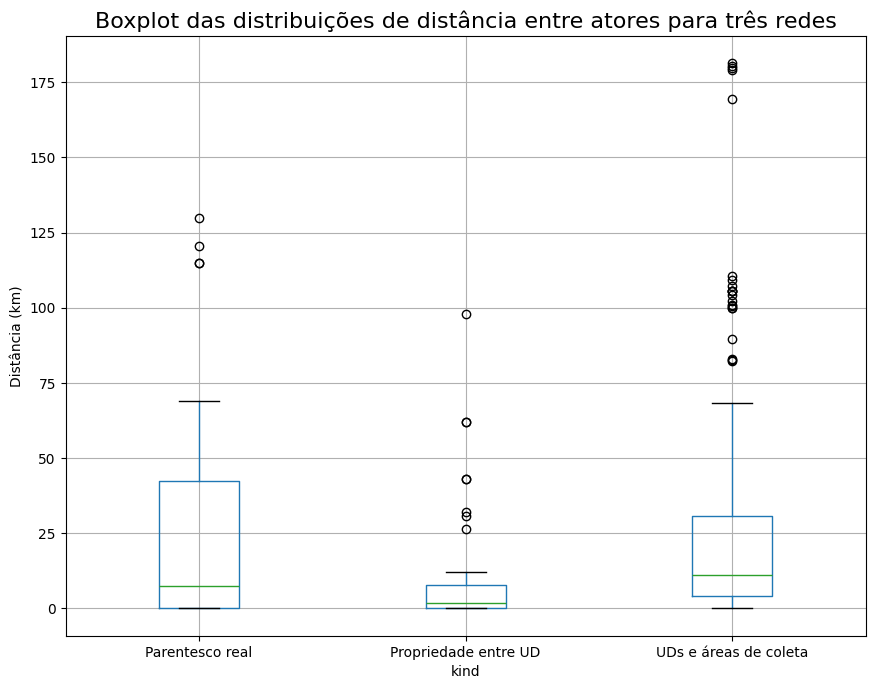

In [27]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

dfDistanceAggregation.boxplot(column=["distance"], by="kind", ax=ax)

ax.set_title('Boxplot das distribuições de distância entre atores para três redes', fontsize=16)
fig.suptitle('')

ax.set_ylabel('Distância (km)')

plt.savefig("results/distance_boxplot.png", format = "png")

In [28]:
dfDistanceAggregation.groupby(['kind']).describe()

distance                                            \
                         count       mean        std       min       25%   
kind                                                                       
Parentesco real           75.0  23.683340  32.062595  0.000000  0.000000   
Propriedade entre UD      48.0  10.445785  20.211167  0.000000  0.000000   
UDs e áreas de coleta    214.0  26.540032  36.844709  0.024745  4.047327   

                                                         
                             50%        75%         max  
kind                                                     
Parentesco real         7.552180  42.395004  129.841192  
Propriedade entre UD    1.745105   7.645342   97.974573  
UDs e áreas de coleta  10.994188  30.667112  181.417249

In [29]:
dfDistanceAggregation[dfDistanceAggregation['kind']=='UDs e áreas de coleta'].describe()

,distance
count,214.000000
mean,26.540032
std,36.844709
min,0.024745
25%,4.047327
50%,10.994188
75%,30.667112
max,181.417249


In [30]:
dfDistanceAggregation

,distance,kind
0,0.826260,Parentesco real
1,42.922191,Parentesco real
2,69.040380,Parentesco real
3,0.826260,Parentesco real
4,0.000000,Parentesco real
...,...,...
209,15.031277,UDs e áreas de coleta
210,24.878865,UDs e áreas de coleta
211,16.494429,UDs e áreas de coleta
212,22.479672,UDs e áreas de coleta


In [31]:
# For the property network: 
# length of total data frame, number on links above 1 and 5 km, and percentage of links above 1 and 5 km

dfTemp = dfPropriedadeDistance[['distance']]
print(len(dfTemp), len(dfTemp[dfTemp['distance'] < 1]), len(dfTemp[dfTemp['distance'] < 1]) / len(dfTemp))
print(len(dfTemp), len(dfTemp[dfTemp['distance'] < 5]), len(dfTemp[dfTemp['distance'] < 5]) / len(dfTemp))

48 23 0.4791666666666667
48 31 0.6458333333333334


In [32]:
# For the 3 networks: length of total data frame, number on links above 75 km, and percentage of links above 75km
dfTemp = dfPropriedadeDistance[['distance']]
print(len(dfTemp), len(dfTemp[dfTemp['distance'] > 75]), len(dfTemp[dfTemp['distance'] > 75]) / len(dfTemp))

dfTemp = dfParentescoDistance[['distance']]
print(len(dfTemp), len(dfTemp[dfTemp['distance'] > 75]), len(dfTemp[dfTemp['distance'] > 75]) / len(dfTemp))

dfTemp = dfColetaDistance[['distance']]
print(len(dfTemp), len(dfTemp[dfTemp['distance'] > 75]), len(dfTemp[dfTemp['distance'] > 75]) / len(dfTemp))

48 1 0.020833333333333332
75 4 0.05333333333333334
214 22 0.102803738317757


In [33]:
dfColetaMeanDistance = dfColetaDistance[['source', 'distance']].groupby('source').mean()
mean_distance = dfColetaMeanDistance.mean()['distance']
print(mean_distance)
dfColetaMeanDistance[dfColetaMeanDistance['distance'] > mean_distance].sort_values('distance', ascending=False)

24.93251363636366


,distance
source,
04,178.029797
32,105.058486
13,96.887093
22,63.759806
20,62.544704
12,61.541917
03,49.256845
05,43.441615
40,41.245313


In [34]:
# UDs with the same coordinate
dfActorsUDNew = dfActorsUD.reset_index()[['id', 'latitude', 'longitude']]
duplicated_coord = dfActorsUDNew.groupby(['latitude', 'longitude']).count().sort_values('id').tail(12).index.values
dfActorsUD['coordinates'] = list(zip(dfActorsUD['latitude'], dfActorsUD['longitude']))
dfActorsUDNew = dfActorsUD[['familia','coordinates']]
dfActorsUDNew[dfActorsUDNew['coordinates'].isin(duplicated_coord)].sort_values('coordinates')

/tmp/ipykernel_68878/2050272979.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfActorsUD['coordinates'] = list(zip(dfActorsUD['latitude'], dfActorsUD['longitude']))


,familia,coordinates
id,,
07,Marinaldo Araújo dos Santos (Naldo),"(-5.7753, -54.2179)"
08,José Alves Gomes da Silva (Zé Boi),"(-5.7753, -54.2179)"
05,Rosinaldo Gomes da Silva (Branquinho),"(-5.4731, -54.3555)"
06,Benedito Gomes da Silva (Bené),"(-5.4731, -54.3555)"
02,Manoel Messias (Manoel da Cachoeirinha),"(-5.4265, -54.3767)"
03,José Martins da Silva,"(-5.4265, -54.3767)"
44,Domingos da Silva,"(-4.928, -54.5894)"
33,José da Rocha de Sousa (Zequinha),"(-4.928, -54.5894)"
27,Mário Marinho,"(-4.928, -54.5894)"


In [35]:
# Property network distance by link type

dfPropriedadeDistanceAlienation = dfPropriedadeDistance[dfPropriedadeDistance['type'].isin(['sociedade', 'doacao', 'heranca'])]
dfPropriedadeDistancePartnership = dfPropriedadeDistance[dfPropriedadeDistance['type'].isin(['compra', 'aviamento'])]

print(dfPropriedadeDistanceAlienation['distance'].describe())
print(dfPropriedadeDistancePartnership['distance'].describe())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: distance, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: distance, dtype: float64


## Area of clusters

In [36]:
# Add computation of area for each cluster in parentesco network

dfActorsParentesco = dfActorsParentesco.sort_values('community')
community_to_area = dict()

for community_id in dfActorsParentesco['community'].unique():
    dfCommunity = dfActorsParentesco[dfActorsParentesco['community'] == community_id]
    latitude = list(dfCommunity['latitude'])
    longitude = list(dfCommunity['longitude'])
    polygon_geom = PolygonS(zip(longitude, latitude)).convex_hull

    if polygon_geom.area == 0:
        community_to_area[community_id] = 0.0
        continue

    coordinates = [[lon,lat] for (lon,lat) in zip(*polygon_geom.exterior.coords.xy)]
    geo_json = {'type':'Polygon','coordinates':[coordinates]}
    community_to_area[community_id] = area_geo(geo_json) / 1000000

print(community_to_area)
print("average: ", sum(community_to_area.values()) / len(community_to_area))

{0: 139.28621026289974, 1: 206.89659766783106, 2: 39.49523567780015, 3: 0.0, 4: 0.0, 5: 128.40536457003063, 6: 1609.122494796026}
average:  303.3151289963697


In [37]:
# Add computation of area for each cluster in propriedade network

dfActorsPropriedade = dfActorsPropriedade.sort_values('community')
community_to_area = dict()

for community_id in dfActorsPropriedade['community'].unique():
    dfCommunity = dfActorsPropriedade[dfActorsPropriedade['community'] == community_id]
    latitude = list(dfCommunity['latitude'])
    longitude = list(dfCommunity['longitude'])
    
    if len(dfCommunity) < 3:
        community_to_area[community_id] = 0.0
        continue
        
    polygon_geom = PolygonS(zip(longitude, latitude)).convex_hull
    if polygon_geom.area == 0:
        polygon_geom = PolygonS(zip(longitude, latitude))
        if polygon_geom.area == 0:
            community_to_area[community_id] = 0.0
            continue


    coordinates = [[lon,lat] for (lon,lat) in zip(*polygon_geom.exterior.coords.xy)]
    geo_json = {'type':'Polygon','coordinates':[coordinates]}
    community_to_area[community_id] = area_geo(geo_json) / 1000000

print(community_to_area)
print("average: ", sum(community_to_area.values()) / len(community_to_area))

{0: 2.022832213559903, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 9.229087913583164, 6: 0.0, 7: 203.8658865790267, 8: 0.0, 9: 632.0808878932601, 10: 0.0}
average:  77.0180631454027


In [38]:
# Check area result for one community

dfCommunity = dfActorsPropriedade[dfActorsPropriedade['community'] == 10]
print(dfCommunity)
latitude = list(dfCommunity['latitude'])
longitude = list(dfCommunity['longitude'])

if len(dfCommunity) < 3:
    print("two actors")
else:
    polygon_geom = PolygonS(zip(longitude, latitude)).convex_hull
    if polygon_geom.area == 0:
        print("no area")
    else:
        coordinates = [[lon,lat] for (lon,lat) in zip(*polygon_geom.exterior.coords.xy)]
        geo_json = {'type':'Polygon','coordinates':[coordinates]}
        community_to_area[community_id] = area_geo(geo_json) / 1000000

    latitude  longitude  community
id                                
34   -4.8433   -54.6214         10
30   -4.8433   -54.6214         10
28   -4.8433   -54.6214         10
no area


## Average distance of cluster

In [39]:
# Build dataframe with combinatin of all UDs in community
groups = dfActorsPropriedade.groupby("community")
combination_dict = { "source": [], "target": [], "community": [] }
for name, group in groups:
    uds = list(group.index.values)
    links = list(combinations(uds, 2))
    source, target = zip(*links)
    combination_dict["source"] += list(source)
    combination_dict["target"] += list(target)
    combination_dict["community"] += [name] * len(source)

dfPropriedadeComDistance = pd.DataFrame.from_dict(combination_dict)


# Bring geolocation data from UDs
dfPropriedadeComDistance = dfPropriedadeComDistance.merge(
    dfActorsUD, right_on='id', left_on='source',  how='left'
)
dfPropriedadeComDistance = dfPropriedadeComDistance.merge(
    dfActorsUD, right_on='id', left_on='target',  how='left', suffixes=['', '_target']
)
relevant_collums = [
    'source', 'target', 'community', 'latitude', 'longitude', 'latitude_target', 'longitude_target'
]
rename = {'latitude': 'latitude_source', 'longitude': 'longitude_source' }

dfPropriedadeComDistance = dfPropriedadeComDistance[relevant_collums]
dfPropriedadeComDistance = dfPropriedadeComDistance.rename(columns=rename)

dfPropriedadeComDistance['distance'] = dfPropriedadeComDistance.apply(compute_distance, axis=1)

# Compute average distance by community
dfPropriedadeComDistanceGroup = dfPropriedadeComDistance[['community', 'distance']].groupby("community").mean()
print(dfPropriedadeComDistanceGroup)
dfPropriedadeComDistanceGroup.describe()

            distance
community           
0           3.398355
1           0.000000
2           4.531308
3           0.000000
4          30.707308
5           6.887740
6          12.202351
7          26.034967
8          17.652152
9          44.796126
10          0.000000


,distance
count,11.000000
mean,13.291846
std,14.913298
min,0.000000
25%,1.699178
50%,6.887740
75%,21.843559
max,44.796126


In [40]:
# Build dataframe with combinatin of all UDs in community
groups = dfActorsParentesco.groupby("community")
combination_dict = { "source": [], "target": [], "community": [] }
for name, group in groups:
    uds = list(group.index.values)
    links = list(combinations(uds, 2))
    source, target = zip(*links)
    combination_dict["source"] += list(source)
    combination_dict["target"] += list(target)
    combination_dict["community"] += [name] * len(source)

dfParentescoComDistance = pd.DataFrame.from_dict(combination_dict)


# Bring geolocation data from UDs
dfParentescoComDistance = dfParentescoComDistance.merge(
    dfActorsUD, right_on='id', left_on='source',  how='left'
)
dfParentescoComDistance = dfParentescoComDistance.merge(
    dfActorsUD, right_on='id', left_on='target',  how='left', suffixes=['', '_target']
)
relevant_collums = [
    'source', 'target', 'community', 'latitude', 'longitude', 'latitude_target', 'longitude_target'
]
rename = {'latitude': 'latitude_source', 'longitude': 'longitude_source' }

dfParentescoComDistance = dfParentescoComDistance[relevant_collums]
dfParentescoComDistance = dfParentescoComDistance.rename(columns=rename)

dfParentescoComDistance['distance'] = dfParentescoComDistance.apply(compute_distance, axis=1)

# Compute average distance by community
dfParentescoComDistanceGroup = dfParentescoComDistance[['community', 'distance']].groupby("community").mean()
print(dfParentescoComDistanceGroup)
dfParentescoComDistanceGroup.describe()

            distance
community           
0          34.399876
1          71.607420
2           7.030321
3           0.000000
4           7.671988
5          39.095510
6          45.475802


,distance
count,7.000000
mean,29.325845
std,25.806104
min,0.000000
25%,7.351154
50%,34.399876
75%,42.285656
max,71.607420
